In [13]:
import sympy as sp
import numpy as np
from sympy.physics.vector import dynamicsymbols
from sympy.physics.vector import time_derivative
from sympy.physics.vector import ReferenceFrame
N = ReferenceFrame('N')
import pylab as pl
import control
from EoM import *
from sympy.physics.mechanics import *
from numpy.linalg import matrix_rank, eig
import math
import intelligent_robotics as ir
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import WIP_utils as utils
import modern_robotics as mr
import time as t
import Cal_joint as cj
import traj

In [14]:
time_0, traj_0 = utils.Trapezoidal_Traj_Gen_Given_Amax_and_T(4,1,0.014)
time_0

array([[0.   ],
       [0.   ],
       [0.014],
       [0.028],
       [0.042],
       [0.056],
       [0.07 ],
       [0.084],
       [0.098],
       [0.112],
       [0.126],
       [0.14 ],
       [0.154],
       [0.168],
       [0.182],
       [0.196],
       [0.21 ],
       [0.224],
       [0.238],
       [0.252],
       [0.266],
       [0.28 ],
       [0.294],
       [0.308],
       [0.322],
       [0.336],
       [0.35 ],
       [0.364],
       [0.378],
       [0.392],
       [0.406],
       [0.42 ],
       [0.434],
       [0.448],
       [0.462],
       [0.476],
       [0.49 ],
       [0.504],
       [0.518],
       [0.532],
       [0.546],
       [0.56 ],
       [0.574],
       [0.588],
       [0.602],
       [0.616],
       [0.63 ],
       [0.644],
       [0.658],
       [0.672],
       [0.686],
       [0.7  ],
       [0.714],
       [0.728],
       [0.742],
       [0.756],
       [0.77 ],
       [0.784],
       [0.798],
       [0.812],
       [0.826],
       [0.84 ],
       [

In [15]:
time_0, traj_0 = utils.Trapezoidal_Traj_Gen_Given_Amax_and_T(1.8,1.5,0.014)
time_1, traj_1 = utils.Trapezoidal_Traj_Gen_Given_Amax_and_T(4,1,0.014)

horizon_0 = utils.Path_Gen(0, 0.1, traj_0[:,0])
horizon_1 = utils.Path_Gen(0.1, 0.1, traj_1[:,0])
horizon_2 = utils.Path_Gen(0.1, 0, traj_0[:,0])
horizon_3 = utils.Path_Gen(0, 0, traj_1[:,0])
horizon_4 = utils.Path_Gen(0, -0.1, traj_0[:,0])
horizon_5 = utils.Path_Gen(-0.1, -0.1, traj_1[:,0])
horizon_6 = utils.Path_Gen(-0.1, 0, traj_0[:,0])


horizon_0 = np.delete(horizon_0,0)
horizon_1 = np.delete(horizon_1,0)
horizon_2 = np.delete(horizon_2,0)
horizon_3 = np.delete(horizon_3,0)
horizon_4 = np.delete(horizon_4,0)
horizon_5 = np.delete(horizon_5,0)
horizon_6 = np.delete(horizon_6,0)

horizon_1 = np.delete(horizon_1,-1)
# horizon_2 = np.delete(horizon_2,-1)
horizon_3 = np.delete(horizon_3,-1)
# horizon_4 = np.delete(horizon_4,-1)
horizon_5 = np.delete(horizon_5,-1)
horizon_6 = np.delete(horizon_6,-1)


tilt_traj = np.hstack((horizon_0,horizon_1))
tilt_traj = np.hstack((tilt_traj,horizon_2))
tilt_traj = np.hstack((tilt_traj,horizon_3))
tilt_traj = np.hstack((tilt_traj,horizon_4))
tilt_traj = np.hstack((tilt_traj,horizon_5))
tilt_traj = np.hstack((tilt_traj,horizon_6))

tilt_traj.shape


(644,)

In [16]:
time, traj = utils.Trapezoidal_Traj_Gen_Given_Amax_and_T(0.05,9,0.014)
len(time)

644

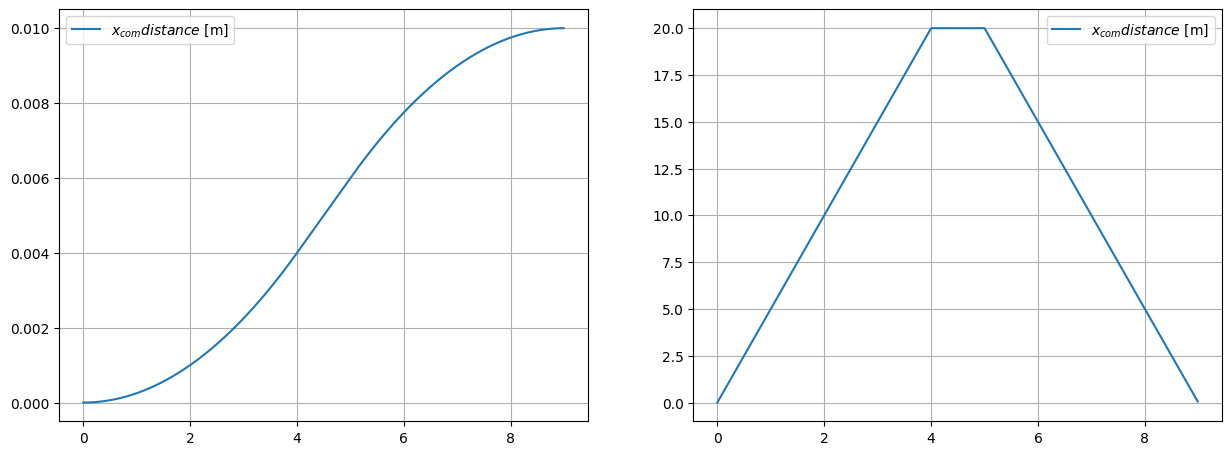

In [29]:
traj_pos = utils.Path_Gen(0, 0.01, traj[:,0])
traj_vel = utils.Path_Gen(0, 0.01, traj[:,1])


pl.figure(1, figsize=(15,12), dpi=100)
pl.subplot(221);
pl.plot(time, traj_pos);
pl.legend([r'$x_{com} distance $ [m]'], loc='best')
pl.grid()

pl.figure(1, figsize=(15,12), dpi=100)
pl.subplot(222);
pl.plot(time, traj_vel*5000);
pl.legend([r'$x_{com} distance $ [m]'], loc='best')
pl.grid()

plt.show()

In [18]:
import sys
sys.stdout = open('time.txt','w')
print(time)
sys.stdout = open('traj_pos.txt','w')
print(traj_pos)
sys.stdout = open('traj_vel.txt','w')
print(traj_vel)

In [8]:
time, traj = utils.Trapezoidal_Traj_Gen_Given_Amax_and_T(0.05,10.5,0.01)
horizon = utils.Path_Gen(0, 0.05, traj[:,2])*50
# *83

In [26]:
np.save('./tilt_traj',tilt_traj)
np.save('./time',time)
np.save('./traj_pos',traj_pos)
np.save('./traj_vel',traj_vel)

In [21]:
sys.stdout = open('tilt_traj.txt','w')
print(tilt_traj)

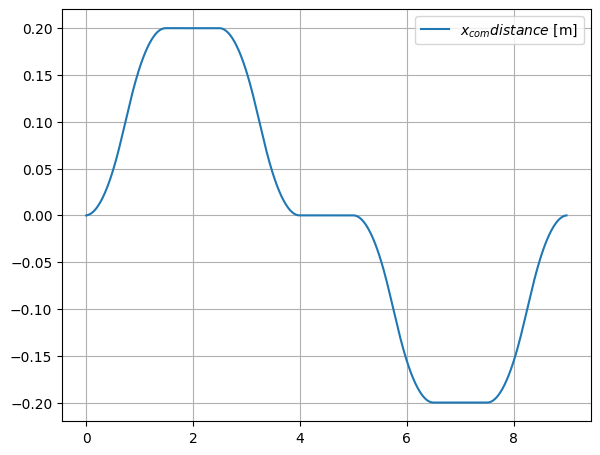

In [20]:

pl.figure(1, figsize=(15,12), dpi=100)
pl.subplot(221);
pl.plot(time, tilt_traj*2);
pl.legend([r'$x_{com} distance $ [m]'], loc='best')
pl.grid()

plt.show()

In [2]:
thetalistd = cj.get_init_pos(0.9)
thetalistd

array([-0.745238866846359, 1.63070174355873, -0.885462876712376],
      dtype=object)

In [3]:
x,z, x_com, z_com, I_by,l,theta_P = cj.get_end_point(thetalistd[0], thetalistd[1], thetalistd[2])
x,z, x_com, z_com, I_by,l,theta_P

(-0.02689698478126435,
 0.7289999999999992,
 -1.1537781497793261e-17,
 0.5004170132265042,
 0.5724430574727477,
 0.5004170132265042,
 -2.3056333403618522e-17)

In [53]:
q2list, q3list, q4list = cj.horizon_angle_traj(0.05,10,0.01,thetalistd,horizon, z_com)


In [7]:
q2list, q3list, q4list = cj.horizon_angle_traj_list(0.05,10,0.01,thetalistd,horizon, z_com)


In [ ]:
import sys
sys.stdout = open('q4list.txt','w')
 
print(q4list)


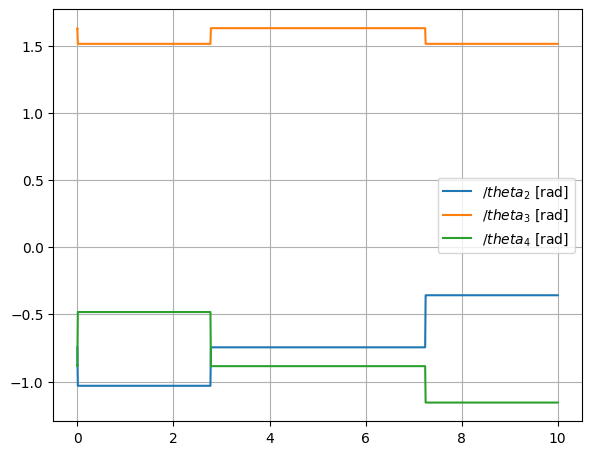

In [56]:
pl.figure(1, figsize=(15,12), dpi=100)
pl.subplot(221);
pl.plot(time, q2list, time, q3list, time, q4list);
pl.legend([r'$/theta_2 $ [rad]', r'$/theta_3 $ [rad]', r'$/theta_4 $ [rad]' ], loc='best')
pl.grid()

plt.show()

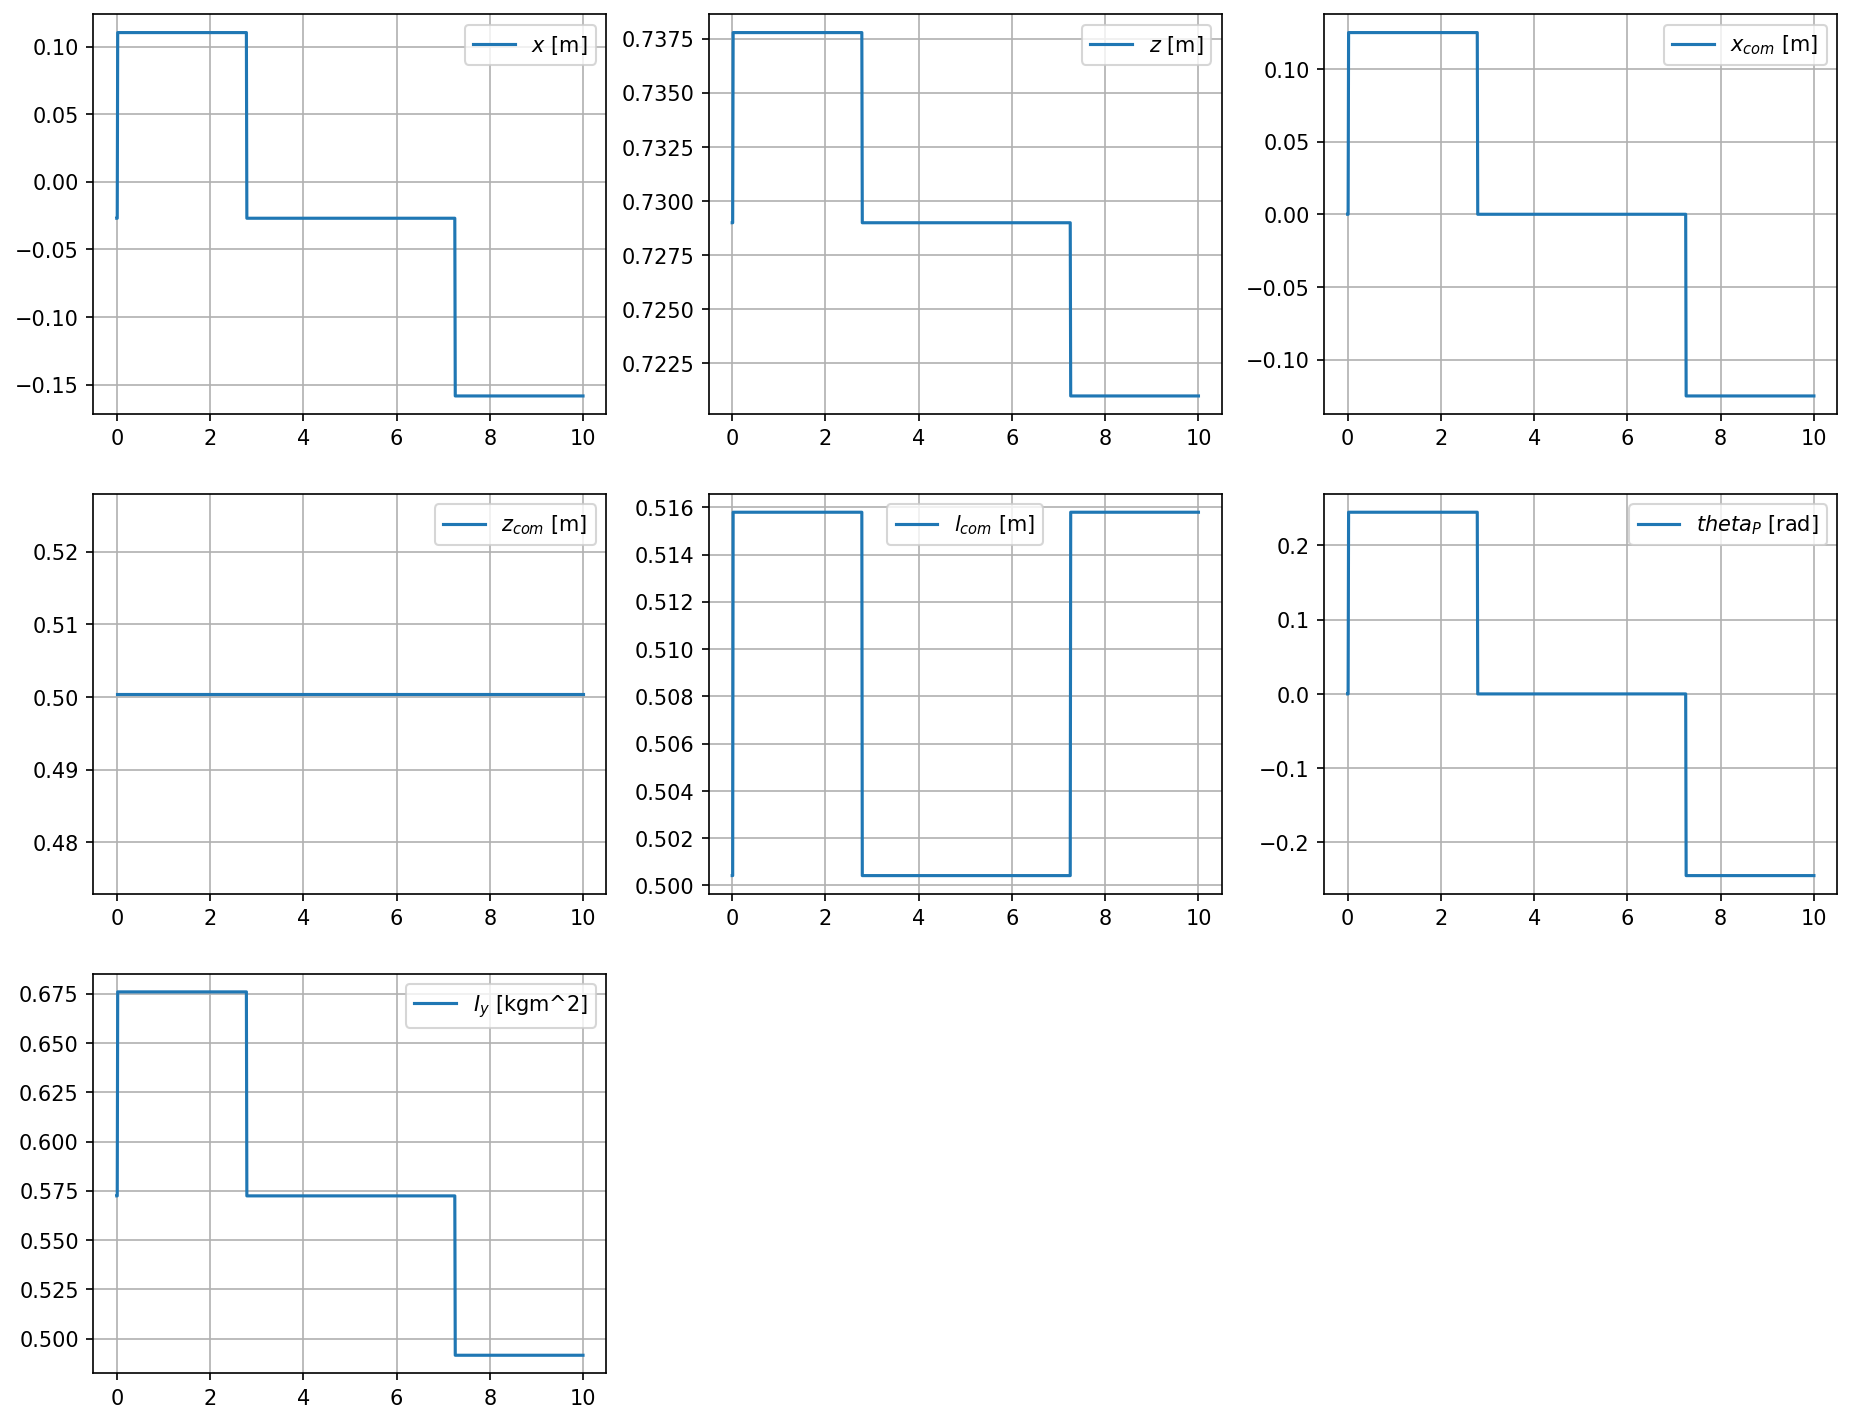

In [57]:

xlist,zlist, x_comlist, z_comlist, l_list, I_list, theta_Plist = cj.end_traj(q2list, q3list, q4list)

pl.figure(1, figsize=(15,12), dpi=150)
pl.subplot(331);
pl.plot(time, xlist);
pl.legend([r'$x$ [m]'], loc='best')
pl.grid()

pl.figure(1, figsize=(15,12), dpi=150)
pl.subplot(332);
pl.plot(time, zlist);
pl.legend([r'$z$ [m]'], loc='best')
pl.grid()

pl.figure(1, figsize=(15,12), dpi=150)
pl.subplot(333);
pl.plot(time, x_comlist);
pl.legend([r'$x_{com}$ [m]'], loc='best')
pl.grid()

pl.figure(1, figsize=(15,12), dpi=150)
pl.subplot(334);
pl.plot(time, z_comlist);
pl.legend([r'$z_{com}$ [m]'], loc='best')
pl.grid()

pl.figure(1, figsize=(15,12), dpi=150)
pl.subplot(335);
pl.plot(time, l_list);
pl.legend([r'$l_{com}$ [m]'], loc='best')
pl.grid()

pl.figure(1, figsize=(15,12), dpi=150)
pl.subplot(336);
pl.plot(time, theta_Plist);
pl.legend([r'$theta_P$ [rad]'], loc='best')
pl.grid()

pl.figure(1, figsize=(15,12), dpi=150)
pl.subplot(337);
pl.plot(time, I_list);
pl.legend([r'$I_y$ [kgm^2]'], loc='best')
pl.grid()


plt.show()

In [58]:
max(theta_Plist)

array([0.24478258])

In [116]:
def get_torque_traj(q2list, q3list, q4list):
    time, traj = utils.Trapezoidal_Traj_Gen_Given_Amax_and_T(0.05,10,0.01)
    # thetalist = get_cur_deg()
    
    m1 = 2.486 + 0.3
    m2 = 1.416
    m3 = 1.739
    m4 = 16.09

    L1 = 0.171
    L2 = 0.28
    L3 = 0.280
    L4 = 0.346

    L1c = L1/2
    L2c = L2 - 0.045289
    L3c = L3 - 0.18878
    L4c = 0.158527

    traj_th2 = q2list
    traj_th3 = q3list
    traj_th4 = q4list

    eint = np.array([ [0.2], [0.2], [0.2]])
    g = np.array([0, 0, -9.8])

    
    M01 = np.array([[1, 0, 0,       0],
                    [0, 1, 0,       0],
                    [0, 0, 1,       0],
                    [0, 0, 0,       1]])
    
    M12 = np.array([[ 1, 0, 0,      0],
                    [ 0, 1, 0,      0],
                    [ 0, 0, 1,       L2c],
                    [ 0, 0, 0,       1]])
    
    M23 = np.array([[1, 0, 0,       0],
                    [0, 1, 0,       0],
                    [0, 0, 1,      (L2-L2c)+L3c],
                    [0, 0, 0,       1]])
    
    M34 = np.array([[1, 0, 0,       0],
                    [0, 1, 0,      0],
                    [0, 0, 1,       (L3-L3c)+L4c],
                    [0, 0, 0,       1]])
    
    G1 = np.diag([0.010192583, 0.009599672, 0.002390603, m2, m2, m2])
    G2 = np.diag([0.008595913, 0.007917693, 0.002944951, m3, m3, m3])
    G3 = np.diag([0.306643651, 0.257336003, 0.140868631, m4, m4, m4]) 
    
    Glist = np.array([G1, G2, G3])
    Mlist = np.array([M01, M12, M23, M34])
    Slist = np.array([[0, 1, 0,      0, 0,     0],
                      [0, 1, 0,   L2,0,     0],
                      [0, 1, 0, (L2+L3), 0, 0.0]]).T
    Kp = 0.1
    Ki = 0.1
    Kd = 0.1
    dt = 0.01

    torquelist = np.array([[0],[0],[0]])
    dthetalist = np.array([[0], [0], [0]])
    

    for i in range(0, len(time)-1):

        thetalist = np.array([traj_th2[i], traj_th3[i], traj_th4[i]],dtype=float)
        thetalistd = np.array([traj_th2[i+1], traj_th3[i+1], traj_th4[i+1]],dtype=float)
        
        dthetalistd = np.array([ (traj_th2[i+1]-traj_th2[i])/dt, (traj_th3[i+1]-traj_th3[i])/dt, (traj_th4[i+1]-traj_th4[i])/dt],dtype=float)
        ddthetalistd = np.array([(dthetalistd[0]-dthetalist[0])/dt, (dthetalistd[1]-dthetalist[1])/dt, (dthetalistd[2]-dthetalist[2])/dt],dtype=float)

        # torque = mr.ComputedTorque(thetalist, dthetalist, eint, g, Mlist, Glist, Slist,thetalistd, dthetalistd, ddthetalistd, Kp, Ki, Kd)

        # torquelist = np.vstack((torquelist,torque))  
        # dthetalist = dthetalistd

        e = np.subtract(thetalistd, thetalist)
        # print(np.subtract(dthetalistd, dthetalist))

        a = mr.MassMatrix(thetalist, Mlist, Glist, Slist)
        c = Kp * e + Ki * (np.array(eint) + e) \
                + Kd * (np.subtract(dthetalistd, dthetalist))
        # print(a)
        # print( Ki * (np.array(eint) + e))
        
        b = np.array([mr.InverseDynamics(thetalist, dthetalist, ddthetalistd, g, \
                            [0, 0, 0, 0, 0, 0], Mlist, Glist, Slist)]).T
        torque = np.dot(a,c)+b
        # print(a).
        # print(thetalistd)
        # print(thetalist)
        # print(dthetalistd)
        # print(dthetalist)
   
        torquelist = np.vstack((torquelist,torque))  
        dthetalist = dthetalistd
        
        
        # print('------------------------')

        
    return torquelist


In [117]:
torquelist = get_torque_traj( q2list, q3list, q4list)
torque = torquelist.reshape(len(time),3)


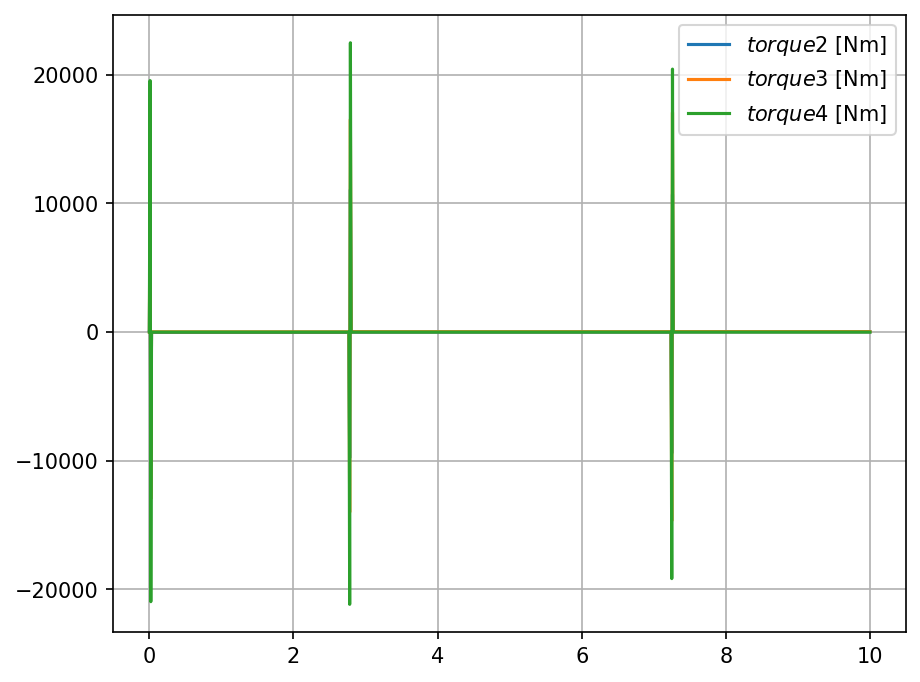

In [118]:

pl.figure(1, figsize=(15,12), dpi=150)
pl.subplot(221);
pl.plot(time,torque);
pl.legend([ r'$torque2$ [Nm]', r'$torque3$ [Nm]', r'$torque4$ [Nm]'], loc='best')
pl.grid()

plt.grid(True, axis='y')

plt.show()

In [119]:
r, L_1 = sp.symbols('r, L_1')
L_1c, L_b = sp.symbols('L_1c, L_b')
m_w, m_1, g, m_b = sp.symbols('m_w, m_1, g, m_b')
I_w, I_1, I_b = sp.symbols('I_w, I_1, I_b')
theta_w, theta_1, theta_2 = dynamicsymbols('theta_w, theta_1, theta_2')

q = sp.Matrix([[theta_w], [theta_1], [theta_2]])
# q = sp.Matrix([[theta_w], [theta_1], [theta_2], [theta_3], [theta_4]])""

qd = q.diff()
qdd = qd.diff()

Ml = sp.Matrix([[1.0*I_w + 1.0*m_1*r**2 + 1.0*m_b*r**2 + 1.0*m_w*r**2, 1.0*r*(L_1*m_b + L_1c*m_1), 2.0*L_b*m_b*r], 
                [1.0*r*(L_1*m_b + L_1c*m_1), 1.0*I_1 + m_b*L_1**2 + L_1c**2*m_1, 1.0*L_1*L_b*m_b], 
                [2.0*L_b*m_b*r, 1.0*L_1*L_b*m_b, 1.0*I_b + m_b*L_b**2]])
Cl = sp.Matrix([[0],
                [0],
                [0]])
Gl = sp.Matrix([[0], 
                [-g*(L_1*m_b + L_1c*m_1)*theta_1], 
                [-L_b*g*m_b*theta_2]])
Wl = sp.Matrix([[1, 1],
                [-1, 1],
                [0, 1]])

T_w, T_b= sp.symbols('T_w,T_b')
u = sp.Matrix([[T_w], [T_b]])

In [11]:
# Rough 한 조건식
vmax_ = 22/3.6
t_ = 20# sec

target_pos = vmax_*t_
v = vmax_/target_pos
a = v/4
target_pos

122.22222222222221

NameError: name 'target_pos' is not defined

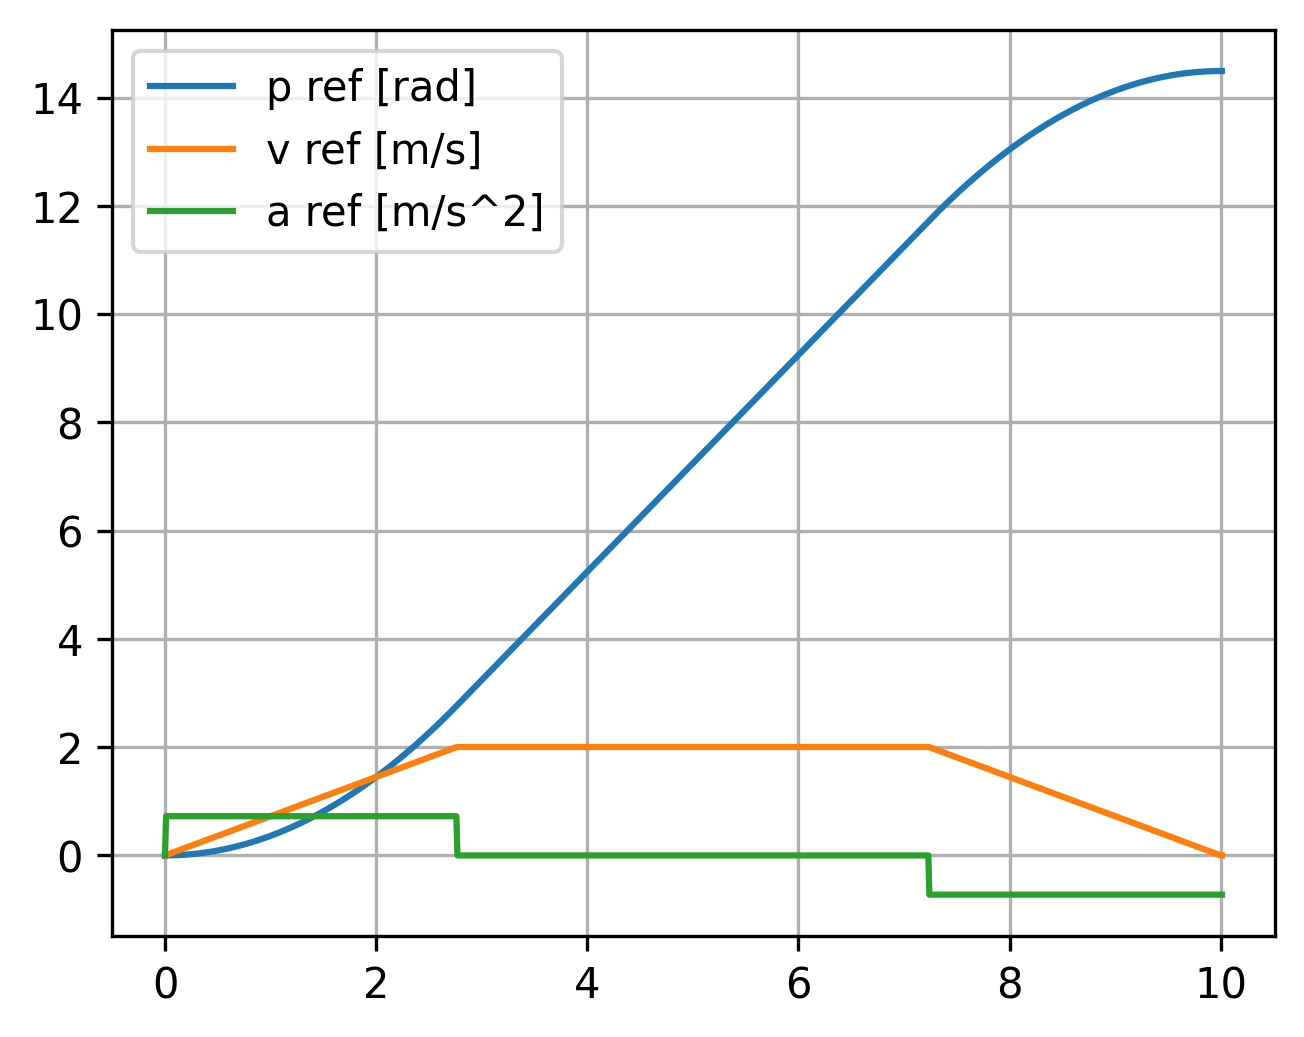

In [2]:
t_s, traj_s = Trapezoidal_Traj_Gen_Given_Amax_and_T(0.05,10,0.01)


phi_traj = traj_s/ 0.069

pl.figure(1, figsize=(5,4), dpi=300)
pl.plot(t_s, phi_traj)
pl.legend(['p ref [rad]', 'v ref [m/s]', 'a ref [m/s^2]'], loc='best')
pl.grid()

print('Vmax :', max(traj_s[:,1])*target_pos*3.6, 'km/r and Amax:', max(traj_s[:,2])*target_pos/9.81, 'g')

In [54]:
phi_traj_0 = phi_traj[:,0].reshape(302,1)
phi_traj_1 = phi_traj[:,1].reshape(302,1)


In [61]:
sub_matrix =np.array([row_element for row in theta_Plist for row_element in row]) 
sub_matrix.shape

(1002,)

In [475]:
max(sub_matrix)

0.19723914186199631

In [74]:
# q = sp.Matrix([[theta_w], [theta_1], [theta_2]])

theta_w_des = phi_traj[:,0]*20
theta_wdot_des = phi_traj[:,1]*20
theta_2_des =  sub_matrix/2 # using acceleration as xl_des
zeros = np.zeros(len(traj_s))
Xdes = theta_w_des
Xdes = np.vstack((Xdes, zeros))
Xdes = np.vstack((Xdes, theta_2_des)) 
Xdes = np.vstack((Xdes, theta_wdot_des))
Xdes = np.vstack((Xdes, zeros))
Xdes = np.vstack((Xdes, zeros))
Xdes.shape, Xdes

((6, 1002),
 array([[ 0.00000000e+00,  7.24637681e-04,  2.89855072e-03, ...,
          2.89854348e+02,  2.89855072e+02,  2.89855072e+02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-1.15281667e-17, -1.15281667e-17, -5.76408335e-18, ...,
         -1.22391288e-01, -1.22391288e-01, -1.22391288e-01],
        [ 0.00000000e+00,  1.44927536e-01,  2.89855072e-01, ...,
          1.44927536e-01,  2.44570869e-12,  2.44570869e-12],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]))

In [135]:
def get_K_list(l_list, I_list):
    
    K_list = np.array([[0,0,0,0,0,0],
                [0,0,0,0,0,0]])
    A_list = np.array([[0,0,0,0,0,0],
                [0,0,0,0,0,0],
                [0,0,0,0,0,0],
                [0,0,0,0,0,0],
                [0,0,0,0,0,0],
                [0,0,0,0,0,0]])
    B_list = np.array([[0,0],
                [0,0],
                [0,0],
                [0,0],
                [0,0],
                [0,0]])
    
    for i in range(0, len(l_list)-1):
        A = np.array([[0, 0, 0, 1, 0, 0], 
                  [0, 0, 0, 0, 1, 0], 
                  [0, 0, 0, 0, 0, 1], 
                  [0, 36.38327895*(-4.03897944233686e-5*I_list[i] + 0.000602131849327921*l_list[i]**2)/(1.71246651092543e-6*I_list[i] - 0.000171795573073423*l_list[i]**2), -0.0249943331150062*l_list[i]**2/(1.71246651092543e-6*I_list[i] - 0.000171795573073423*l_list[i]**2), 0, 0, 0], 
                  [0, 36.38327895*(0.000157830060563906*I_list[i] - 0.00619263160146842*l_list[i]**2)/(1.41985307904244e-5*I_list[i] - 0.00142440434214589*l_list[i]**2), 0.0698504009018772*l_list[i]**2/(1.41985307904244e-5*I_list[i] - 0.00142440434214589*l_list[i]**2), 0, 0, 0], 
                  [0, 1.24065620633138*l_list[i]/(0.00130861243725002*I_list[i] - 0.131280712442595*l_list[i]**2), 0.247057456741339*l_list[i]/(0.00130861243725002*I_list[i] - 0.131280712442595*l_list[i]**2), 0, 0, 0]],dtype=float)
        B = np.array([[0, 0], 
                  [0, 0], 
                  [0, 0], 
                  [-(-4.03897944233686e-5*I_list[i] + 0.000602131849327921*l_list[i]**2)/(1.71246651092543e-6*I_list[i] - 0.000171795573073423*l_list[i]**2) + (9.9897358790352e-5*I_list[i] + 0.000213226707935062*l_list[i]**2)/(1.71246651092543e-6*I_list[i] - 0.000171795573073423*l_list[i]**2), -0.000132389831930113*l_list[i]/(1.71246651092543e-6*I_list[i] - 0.000171795573073423*l_list[i]**2) + (-4.03897944233686e-5*I_list[i] + 0.000602131849327921*l_list[i]**2)/(1.71246651092543e-6*I_list[i] - 0.000171795573073423*l_list[i]**2) + (9.9897358790352e-5*I_list[i] + 0.000213226707935062*l_list[i]**2)/(1.71246651092543e-6*I_list[i] - 0.000171795573073423*l_list[i]**2)], 
                  [(-0.000334882893230537*I_list[i] + 0.00499244075608668*l_list[i]**2)/(1.41985307904244e-5*I_list[i] - 0.00142440434214589*l_list[i]**2) - (0.000157830060563906*I_list[i] - 0.00619263160146842*l_list[i]**2)/(1.41985307904244e-5*I_list[i] - 0.00142440434214589*l_list[i]**2), 0.000369983179511139*l_list[i]/(1.41985307904244e-5*I_list[i] - 0.00142440434214589*l_list[i]**2) + (-0.000334882893230537*I_list[i] + 0.00499244075608668*l_list[i]**2)/(1.41985307904244e-5*I_list[i] - 0.00142440434214589*l_list[i]**2) + (0.000157830060563906*I_list[i] - 0.00619263160146842*l_list[i]**2)/(1.41985307904244e-5*I_list[i] - 0.00142440434214589*l_list[i]**2)], 
                  [-0.135267724525529*l_list[i]/(0.00130861243725002*I_list[i] - 0.131280712442595*l_list[i]**2), -0.0670684724440239*l_list[i]/(0.00130861243725002*I_list[i] - 0.131280712442595*l_list[i]**2) + 0.00130861243725002/(0.00130861243725002*I_list[i] - 0.131280712442595*l_list[i]**2)]],dtype=float)

        C = np.array([[1,0,0,0,0,0],
                  [0,1,0,0,0,0],
                  [0,0,1,0,0,0],
                  [0,0,0,1,0,0],
                  [0,0,0,0,1,0],
                  [0,0,0,0,0,1]])
        D = np.array([[0,0],
                [0,0],
                [0,0],
                [0,0],
                [0,0],
                [0,0]])
        
        # print(A)
        
        # ss0 = [A, B, C, D]
        # sys0 = control.ss(*[pl.array(mat_i.subs(param)).astype(float) for mat_i in ss0])
        
        Q = sp.Matrix([ [0.1,0,0,0,0,0],
                        [0,0.1,0,0,0,0],
                        [0,0,0.1,0,0,0],
                        [0,0,0,1,0,0],
                        [0,0,0,0,1,0],
                        [0,0,0,0,0,1] ])
        R = sp.Matrix([ [6,0],
                        [0,6] ])

        K, S, E = control.lqr(A, B, Q, R)


        K_list = np.vstack((K_list,K))
        A_list = np.vstack((A_list,A))
        B_list = np.vstack((B_list,B))
        # K_list.append(K)
        # A_list.append(A)
        # B_list.append(B)
    return K_list, A_list, B_list

K_list, A_list, B_list = get_K_list(l_list, I_list)
# K_list = np.array(K_list)
# A_list = np.array(A_list)
# B_list = np.array(B_list)

/home/ssc/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
/home/ssc/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.


In [136]:
K_list = K_list.reshape(len(time),2,6)

In [137]:
A_list = A_list.reshape(len(time),6,6) 

In [138]:
B_list = B_list.reshape(len(time),6,2) 

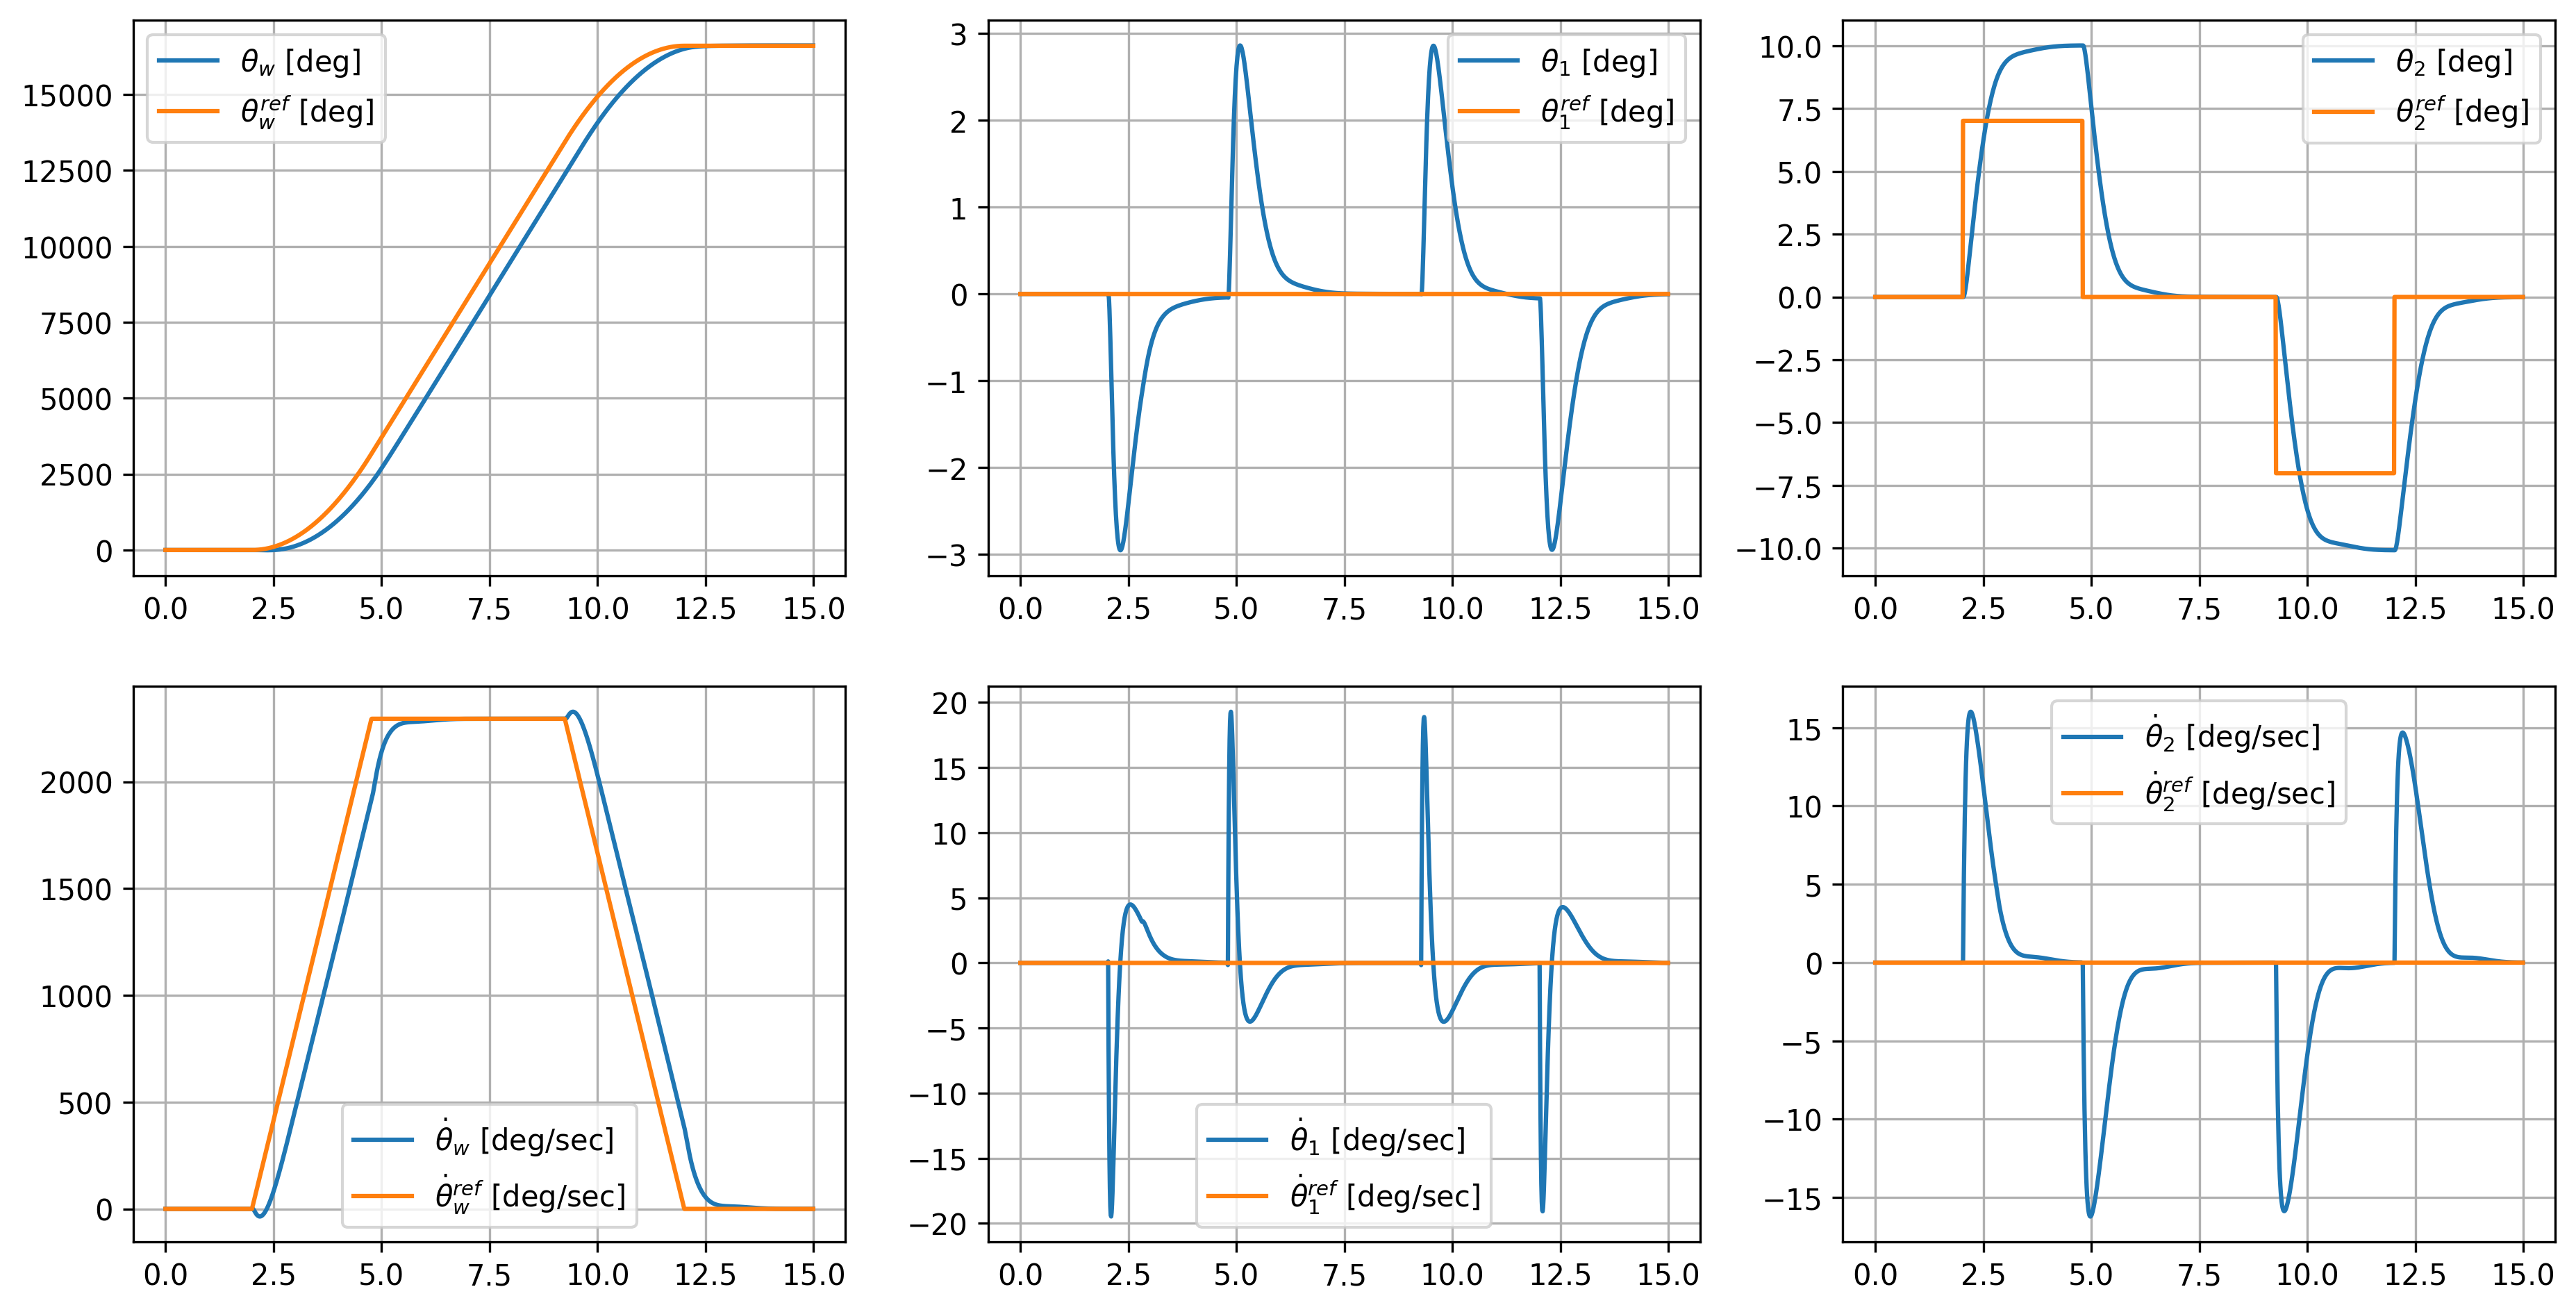

In [139]:
# Closed-loop Simulation

rad2deg = 180/np.pi

def simulate_model_closed(Alist, Blist, X0, Xdes, K_gain, time_array, dt):

        
    t = 0
    j = 0
    X = Xref = Xd_prev = Xd = X0
    
    t_save = [0]
    x_save = xref_save = np.array([0,0,0,0,0,0])
    u_save = np.array([0,0])
    
    for i in range(len(time_array)-1):
        t = time_array[i]
         
        if t<2:
            Xref = X0       
        elif t>=2 and j<(Xdes.shape[1]):
            Xref = Xdes[:,j]
            j+=1
        else:
            Xdes_final = Xdes[:,Xdes.shape[1]-1]
            Xdes_final[2] = 0 # force to set xl_des as 0
            Xref = Xdes_final

        # partial feedback
        # print(i)
        # print(K_gain[i][0][1:])
        # print(Xref[1:].shape)
        # print(X[1:].shape)
        # print('========')
        if i<1002:

            u1 = K_gain[i][0][1:]@(Xref[1:] - X[1:])
            u2 = K_gain[i][1][1:]@(Xref[1:] - X[1:])
            
            # Forward Dynamics
            Xd_prev = Xd
            # Linear Model
            u = [u1, u2]
            # print(u)
            Xd = Alist[i]@X + Blist[i]@u # Xd = [xd, x_ld, thetad, xdd, x_ldd, thetadd]

            t_save = np.vstack((t_save, t))
            x_save = np.vstack((x_save, X))
            # print(xref_save)
            # print(Xref)
            xref_save = np.vstack((xref_save, Xref))
            u_save = np.vstack((u_save, np.array([u1,u2])))

        else:
            u1 = K_gain[-1][0][1:]@(Xref[1:] - X[1:])
            u2 = K_gain[-1][1][1:]@(Xref[1:] - X[1:])
            
            # Forward Dynamics
            Xd_prev = Xd
            # Linear Model
            u = [u1, u2]
            # print(u)
            Xd = Alist[-1]@X + Blist[-1]@u # Xd = [xd, x_ld, thetad, xdd, x_ldd, thetadd]

            t_save = np.vstack((t_save, t))
            x_save = np.vstack((x_save, X))
            # print(xref_save)
            # print(Xref)
            xref_save = np.vstack((xref_save, Xref))
            u_save = np.vstack((u_save, np.array([u1,u2])))
        
        X = X + Xd*dt
        t = t + dt
        
        
        # #limit setting
        # xl_limit = 0.5
        # if X[1] >= xl_limit:
        #     X[1] = xl_limit
        # elif X[1] <= -xl_limit:
        #     X[1] = -xl_limit
                 
    return t_save, x_save, xref_save, u_save

# initial condition
# [x, x_l, theta, x_dot,x_l_dot, theta_dot]
X0 = np.array([0,0,0,0,0,0])

tf = 10+5
dt = 0.01
N = int(tf/dt)

# time points
t = np.linspace(0,tf,N)

# simulation
t_sim, x_sim, xref_sim, u_sim = simulate_model_closed(A_list, B_list, X0, Xdes, K_list, t, dt)

pl.figure(1, figsize=(15,12), dpi=300)
pl.subplot(331);
pl.plot(t_sim, x_sim[:,0]*rad2deg, t_sim, xref_sim[:,0]*rad2deg);
pl.legend([r'$\theta_w$ [deg]', r'$\theta_w^{ref}$ [deg]'], loc='best')
pl.grid()

pl.subplot(332);
pl.plot(t_sim, x_sim[:,1]*rad2deg, t_sim, xref_sim[:,1]*rad2deg);
pl.legend([r'$\theta_1$ [deg]', r'$\theta_1^{ref}$ [deg]'], loc='best')
pl.grid()

pl.subplot(333);
pl.plot(t_sim, x_sim[:,2]*rad2deg, t_sim, xref_sim[:,2]*rad2deg);
pl.legend([r'$\theta_2$ [deg]', r'$\theta_2^{ref}$ [deg]'], loc='best')
pl.grid()

pl.subplot(334);
pl.plot(t_sim, x_sim[:,3]*rad2deg, t_sim, xref_sim[:,3]*rad2deg);
pl.legend([r'$\dot\theta_w$ [deg/sec]', r'$\dot\theta_w^{ref}$ [deg/sec]'], loc='best')
pl.grid()

pl.subplot(335);
pl.plot(t_sim, x_sim[:,4]*rad2deg, t_sim, xref_sim[:,4]*rad2deg);
pl.legend([r'$\dot\theta_1$ [deg/sec]', r'$\dot\theta_1^{ref}$ [deg/sec]'], loc='best')
pl.grid()

pl.subplot(336);
pl.plot(t_sim, x_sim[:,5]*rad2deg, t_sim, xref_sim[:,5]*rad2deg);
pl.legend([r'$\dot\theta_2$ [deg/sec]', r'$\dot\theta_2^{ref}$ [deg/sec]'], loc='best')
pl.grid()

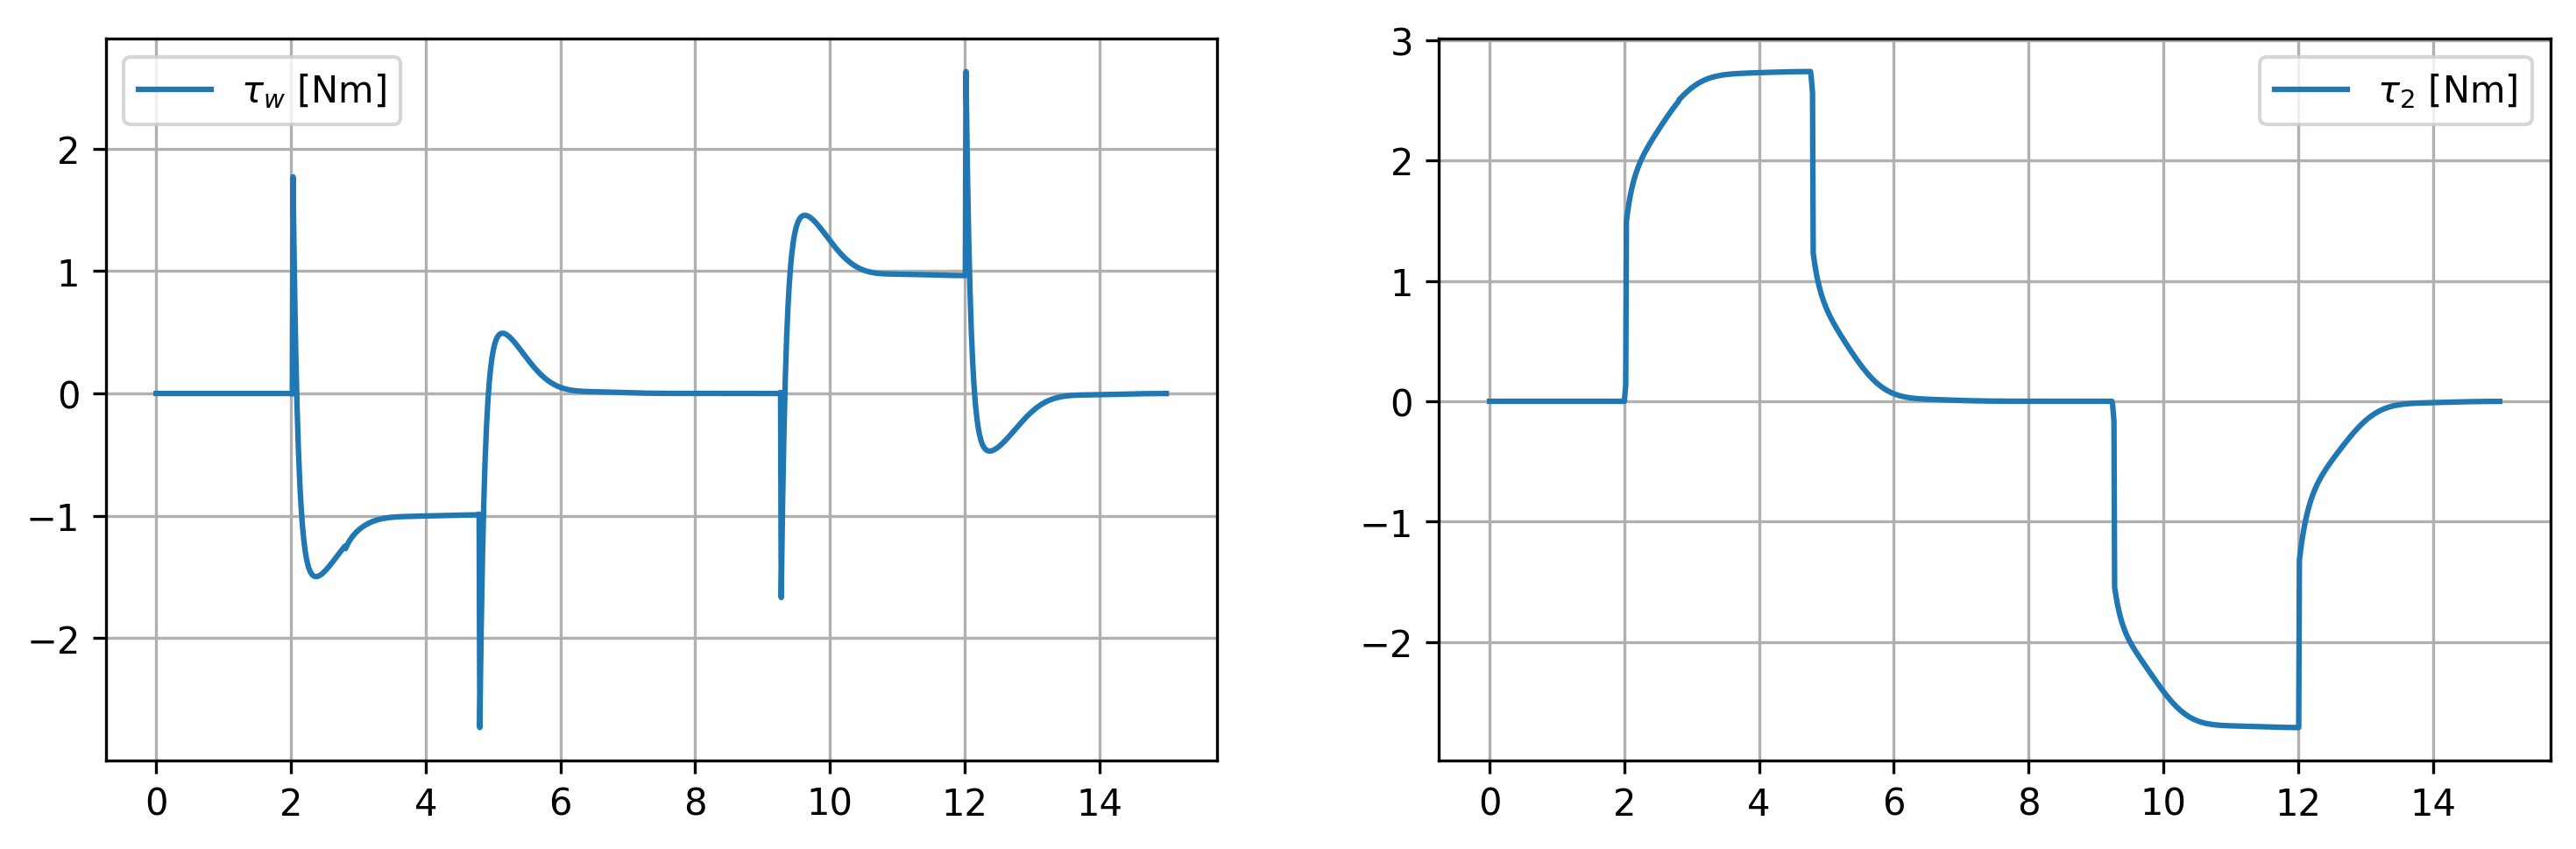

In [140]:
pl.figure(2, figsize=(12,8), dpi=300)
pl.subplot(221);
pl.plot(t_sim, u_sim[:,0]);
pl.legend([r'$\tau_w$ [Nm]'], loc='best')
pl.grid()

pl.subplot(222);
pl.plot(t_sim, u_sim[:,1]);
pl.legend([r'$\tau_2$ [Nm]'], loc='best')
pl.grid()